In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost

Census Income Data Set
Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

The 1994 Census database

This data was extracted from the census bureau database



In [2]:
header_list = ['age', 'workclass', 'fnlwgt',
               'education', 'education-num',
               'marital-status', 'occupation',
               'relationship', 'race', 'sex',
               'capital-gain', 'capital-loss', 
               'hours-per-week', 'native-country', 
               'income']

In [11]:
census = pd.read_csv("/home/mpa/Downloads/adult.csv", 
                   names = header_list,
                    delimiter = ',', na_values = ' ?')
census.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
# sums the null values of each column
census.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [13]:
census.isna().sum().sum()

4262

<Figure size 720x432 with 0 Axes>

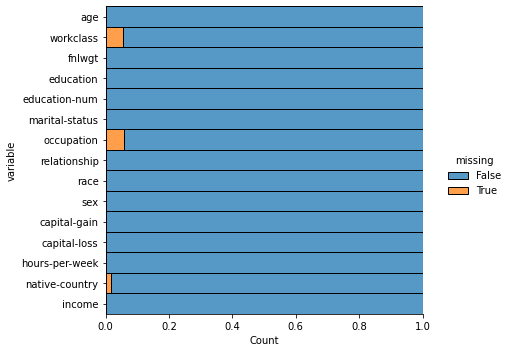

In [14]:
_ = plt.figure(figsize = (10,6))
_ = sns.displot(data = census.isna().melt(value_name = "missing"), 
            y = "variable", 
            hue = "missing", 
            multiple = "fill", 
            aspect = 1.25)

<AxesSubplot:>

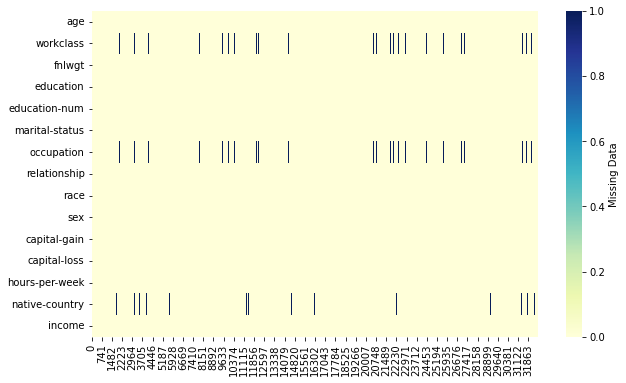

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(census.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [16]:
census[census.isna().any(axis = 1)] 
# .isna().any gathers (reune) any and all null values 
# while (axis=1) specifies values in the columns

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,NaN,>50K
27,54,NaN,180211,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
38,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,NaN,>50K
51,18,Private,226956,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,30,NaN,<=50K
61,32,NaN,293936,7th-8th,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,NaN,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,>50K
32531,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
32539,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,>50K
32541,41,NaN,202822,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,<=50K


In [17]:
census.iloc[[27, 61]]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,NaN,180211,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,NaN,293936,7th-8th,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,NaN,<=50K


In [18]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [19]:
df1 = census.describe(include = 'object') # 'number'

#df1.loc['dtype'] = census.dtypes # manter essa linha se usar include = 'all'
df1.loc['size'] = len(census)
df1.loc['% count'] = round((census.isnull().mean())*100, 1)

df1

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720
size,32561,32561,32561,32561,32561,32561,32561,32561,32561
% count,5.6,0.0,0.0,5.7,0.0,0.0,0.0,1.8,0.0


In [ ]:
census.describe(exclude = 'number')

In [ ]:
round(census.describe(exclude = 'object'), 3)

In [ ]:
# summarize the class distribution
target = census.values[:,-1]
target

In [ ]:
sum(census['income'] == ' <=50K')

In [ ]:
# TEM OUTRA FORMA DE FAZERE ESSAS OPERAÇÃO NO CASO DE ML. VER ABAIXO.
#census['target_dummy'] = np.where(census['income'] == ' <=50K', 1, 0)

In [ ]:
census.head()

In [ ]:
sns.set()

fig = plt.figure(figsize = (12, 7))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
_ = ax1.boxplot(census['education-num'], vert = False)
_ = ax2.hist(census['education-num'])

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize = (12, 7))
ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
_ = ax1.hist(census['age'])
_ = ax1.set_title('Age')
_ = ax2.hist(census['education-num'])
_ = ax2.set_title('education-num')
_ = ax3.hist(census['capital-loss'])
_ = ax3.set_title('capital-loss')
_ = ax4.hist(census['capital-gain'])
_ = ax4.set_title('capital-gain')
_ = ax5.hist(census['hours-per-week'])
_ = ax5.set_title('hours-per-week')
plt.tight_layout()

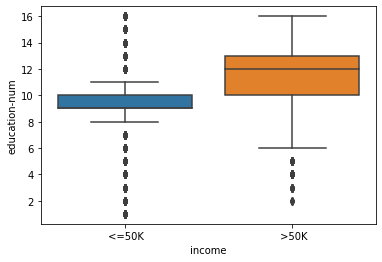

In [23]:
ax = sns.boxplot(x = 'income', y = 'education-num', data = census)


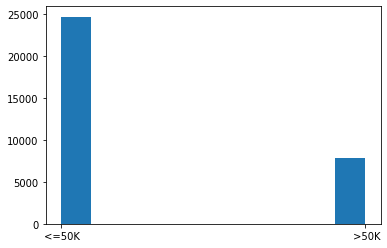

In [24]:
_ = plt.hist(census['income'])

## Predicting classification

In [ ]:
census.info()

### Non-numerical columns
***All columns of the dtype object must be transformed into numerical columns.***

***pandas get_dummies method*** takes the non-numerical unique values of every column and converts them into their own column, with 1 indicating presence and 0 indicating absence. 

For instance, if the column values of a DataFrame called "Book Types" were "hardback," "paperback," or "ebook," pd.get_dummies would create three new columns called "hardback," "paperback," and "ebook" replacing the "Book Types" column.

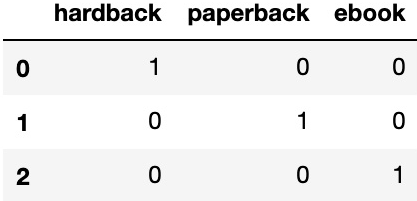

pd.get_dummies will create many new columns, so it's worth checking to see whether any columns may be eliminated. 

A quick review of the df_census data reveals an 'education' column and an education_num column. The education_num column is a numerical conversion of 'education'. Since the information is the same, the 'education' column may be deleted:



In [20]:
df_census = census.drop(['education'], axis = 1)

In [21]:
# Now use pd.get_dummies to transform the non-numerical columns into numerical columns:

df_census = pd.get_dummies(df_census)

df_census.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income_ <=50K,income_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [22]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 91 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   age                                         32561 non-null  int64
 1   fnlwgt                                      32561 non-null  int64
 2   education-num                               32561 non-null  int64
 3   capital-gain                                32561 non-null  int64
 4   capital-loss                                32561 non-null  int64
 5   hours-per-week                              32561 non-null  int64
 6   workclass_ Federal-gov                      32561 non-null  uint8
 7   workclass_ Local-gov                        32561 non-null  uint8
 8   workclass_ Never-worked                     32561 non-null  uint8
 9   workclass_ Private                          32561 non-null  uint8
 10  workclass_ Self-emp-inc           

Tip

Using ***pd.get_dummies may increase memory usage***, as can be verified using the .info() method on the DataFrame in question and checking the last line. 

***Sparse matrices may be used to save memory*** where only values of 1 are stored and values of 0 are not stored. For more information on sparse matrices

The target column is whether or not someone makes 50K. After pd.get_dummies, two columns, df_census['income_<=50K'] and df_census['income_>50K'], are used to determine whether someone makes 50K. 

Since either column will work, we delete df_census['income_ <=50K']:

In [25]:
df_census = df_census.drop('income_ <=50K', axis = 1)

In [26]:
# Now split the data into X (predictor columns) and y (target column). 
# Note that -1 is used for indexing since the last column is the target column:

X = df_census.iloc[:,:-1]
y = df_census.iloc[:,-1]

***It's time to build machine learning classifiers!***

### Logistic regression

Logistic regression is the most fundamental classification algorithm. Mathematically, logistic regression works in a manner similar to linear regression. For each column, logistic regression finds an appropriate weight, or coefficient, that maximizes model accuracy. The primary difference is that instead of summing each term, as in linear regression, logistic regression uses the sigmoid function.

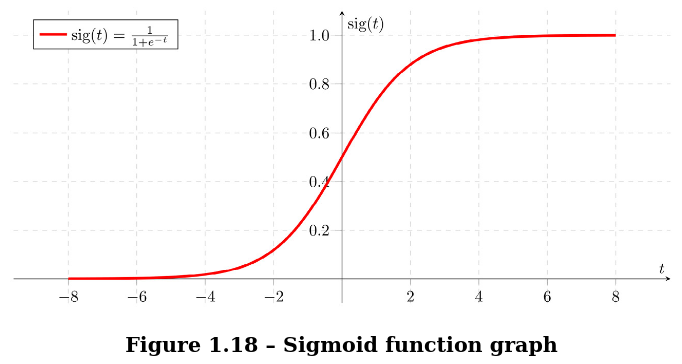

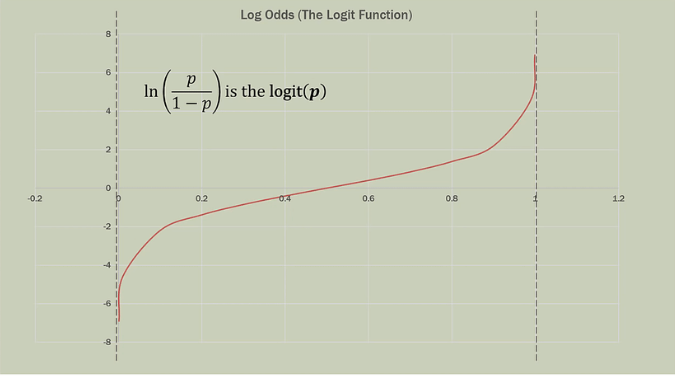

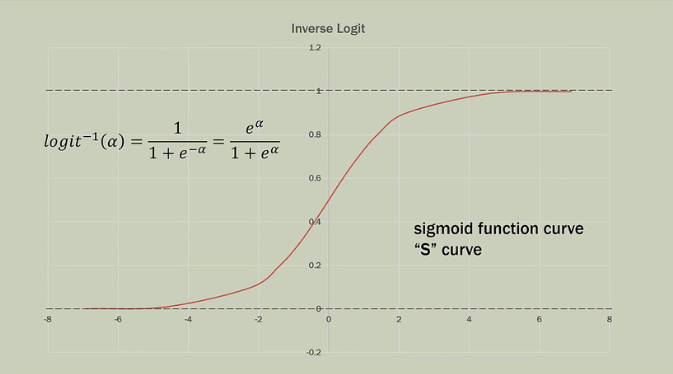

The sigmoid is commonly used for classification. All values greater than 0.5 are matched to 1, and all values less than 0.5 are matched to 0.

Implementing logistic regression with scikit-learn is nearly the same as implementing linear regression.

***The main differences are that the predictor column should fit into categories, and the error should be in terms of accuracy.*** 

As a bonus, the error is in terms of accuracy by default, so explicit scoring parameters are not required.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

### The cross-validation function

Let's use cross-validation on logistic regression to predict whether someone makes over 50K.

In [34]:
def cross_val(classifier, num_splits = 10):
    model = classifier
    scores = cross_val_score(model, X, y, cv = num_splits)
    print('Accuracy:', np.round(scores, 2))
    print('Accuracy mean: %0.2f' % (scores.mean()))

In [35]:
cross_val(LogisticRegression())

/home/mpa/jupyter/environment/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: [0.8  0.8  0.79 0.8  0.79 0.81 0.79 0.79 0.8  0.8 ]
Accuracy mean: 0.80


***Accuracy: [0.8  0.8  0.79 0.8  0.79 0.81 0.79 0.79 0.8  0.8 ]***

***Accuracy mean: 0.80***

80% accuracy isn't bad out of the box.

lbfgs stand for: "Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm". It is one of the solvers' algorithms provided by Scikit-Learn Library.

The term limited-memory simply means it stores only a few vectors that represent the gradients approximation implicitly.

It has better convergence on relatively small datasets.

But what is algorithm convergence?

In simple words. If the error of solving is ranging within very small range (i.e., it is almost not changing), then that means the algorithm reached the solution (not necessary to be the best solution as it might be stuck at what so-called "local Optima").

On the other hand, if the error is varying noticeably (even if the error is relatively small [like in your case the score was good], but rather the differences between the errors per iteration is greater than some tolerance) then we say the algorithm did not converge.

Now, you need to know that Scikit-Learn API sometimes provides the user the option to specify the maximum number of iterations the algorithm should take while it's searching for the solution in an iterative manner:

LogisticRegression(... solver='lbfgs', max_iter=100 ...)

As you can see, the default solver in LogisticRegression is 'lbfgs' and the maximum number of iterations is 100 by default.

Final words, please, however, note that increasing the maximum number of iterations does not necessarily guarantee convergence, but it certainly helps!

Update:
Based on your comment below, some tips to try (out of many) that might help the algorithm to converge are:

Increase the number of iterations;

Try a different optimizer: (https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions/52388406#52388406);

Scale your data:(https://scikit-learn.org/stable/modules/preprocessing.html);

Add engineered features: (https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)

Data pre-processing: (https://datascience.stackexchange.com/questions/80421/very-low-cross-val-score-for-regression-with-big-corr-between-feature-and-res/80422#80422) e (https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114)

Add more data: (https://www.quora.com/How-do-you-determine-sample-size-for-machine-learning-classification/answer/Yahya-Almardeny)

### The XGBoost classifier

XGBoost has a regressor and a classifier. To use the classifier, import the following algorithm:

In [36]:
from xgboost import XGBClassifier

Now run the classifier in the cross_val function with one important addition. 

***Since there are 94 columns, and XGBoost is an ensemble method, meaning that it combines many models for each run, each of which includes 10 splits, we are going to limit n_estimators, the number of models, to 5.***

Normally, XGBoost is very fast. 

In fact, it has a reputation for being the fastest boosting ensemble method out there, a reputation that we will check in this book! 

For our initial purposes, however, 5 estimators, though not as robust as the default of 100, is sufficient.

In [37]:
cross_val(XGBClassifier(n_estimators = 5))

/home/mpa/jupyter/environment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/mpa/jupyter/environment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/mpa/jupyter/environment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/mpa/jupyter/environment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/mpa/jupyter/environment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/mpa/jupyter/environment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/mpa/jupyter/environment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/mpa/jupyter/environment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/mpa/jupyter/environment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/mpa/jupyter/environment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: [0.85 0.86 0.87 0.85 0.86 0.86 0.86 0.87 0.86 0.86]
Accuracy mean: 0.86


***Accuracy: [0.85 0.86 0.87 0.85 0.86 0.86 0.86 0.87 0.86 0.86]***

***Accuracy mean: 0.86***

As you can see, XGBoost scores higher than logistic regression out of the box.